## 2. Time Series Decomposition and Understanding Multiple Seasonality Structures using MSTL

**Overview:**
- In this notebook, we use MSTL (Multiple Seasonal-Trend decomposition using LOESS) to decompose the multiple seasonalities (daily, weekly, yearly) present in electricity generation and demand time series data, and visualize and analyze their structure.

### 2-1. Preparation for Analysis

#### 2-1-1. Importing Libraries and Loading Data

In [1]:
# Import libraries
from pathlib import Path
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import STL, MSTL
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

from src.data_utils import load_timeseries_data

import warnings
# Hide warnings
warnings.filterwarnings("ignore")

# Japanese font settings (to prevent garbled characters) windows or mac
plt.rcParams['font.family'] = 'Meiryo' # For Windows
# plt.rcParams['font.family'] = 'Hiragino Sans' # For Mac

In [2]:
# Load data
BASE_DIR = Path().resolve()
DATA_DIR = BASE_DIR.parent / "data"
target_file = DATA_DIR / "e_gen_demand.csv"

df = load_timeseries_data(target_file)
df.head()

series_gen = df['solar_gen_mw'].copy() # Generation
series_demand = df['e_demand_mw'].copy() # Consumption

print("Data preparation complete. Analysis period: ", series_gen.index.min(), " ~ ", series_gen.index.max())

Data preparation complete. Analysis period:  2023-01-01 00:00:00  ~  2025-03-31 23:30:00


### 2-2. MSTL Decomposition using Primary Cycles (Daily and Weekly)

#### 2-2-1. Preparation for Decomposition and Definition of Execution Functions

In [3]:
# MSTL Period Determination
# Define the periods for analysis
# Daily period: 48 (30 minutes * 48 frames/day)
# Weekly period: 336 (48 frames * 7 days/week)
# Annual period (48*365) is omitted this time due to short data duration or high computational load.
PERIODS = [48, 336]

print(f"MSTL analysis ready. Periods: {PERIODS}")

MSTL analysis ready. Periods: [48, 336]


In [4]:
def perform_mstl_decomposition(series, series_name, periods):
    """Function to perform MSTL decomposition and visualize the results with matplotlib"""

    print(f"\n==================================================")
    print(f"  MSTL Decomposition: {series_name} (Periods: {periods})")
    print(f"==================================================")
    
    # Perform MSTL decomposition
    mstl = MSTL(
        series.dropna(), 
        periods=periods, 
        stl_kwargs={"robust": True, "seasonal_deg":0} 
    )
    res = mstl.fit()

    # --- Visualize with matplotlib ---
    fig, axes = plt.subplots(5, 1, figsize=(12, 15), sharex=True)
    fig.suptitle(f"{series_name} MSTL Decomposition Results (Daily and Weekly Periods)", fontsize=16)

    # Observed values
    axes[0].plot(res.observed)
    axes[0].set_ylabel("Observed")

    # Trend
    axes[1].plot(res.trend)
    axes[1].set_ylabel("Trend")

    # Seasonality 1 (Daily Period)
    axes[2].plot(res.seasonal.iloc[:, 0])
    axes[2].set_ylabel(f"Seasonal (P={periods[0]})")

    # Seasonality 2 (Weekly Period)
    axes[3].plot(res.seasonal.iloc[:, 1])
    axes[3].set_ylabel(f"Seasonal (P={periods[1]})")

    # Residuals
    axes[4].plot(res.resid, marker='.', linestyle='None', markersize=2)
    axes[4].set_ylabel("Residual")
    axes[4].set_xlabel("Date")

    plt.tight_layout(rect=[0, 0, 1, 0.97]) # Adjust for suptitle overlap
    plt.show()

#### 2-2-2. Power Generation (solar_gen_mw) Decomposition Results


  MSTL Decomposition: Generation (solar_gen_mw) (Periods: [48, 336])


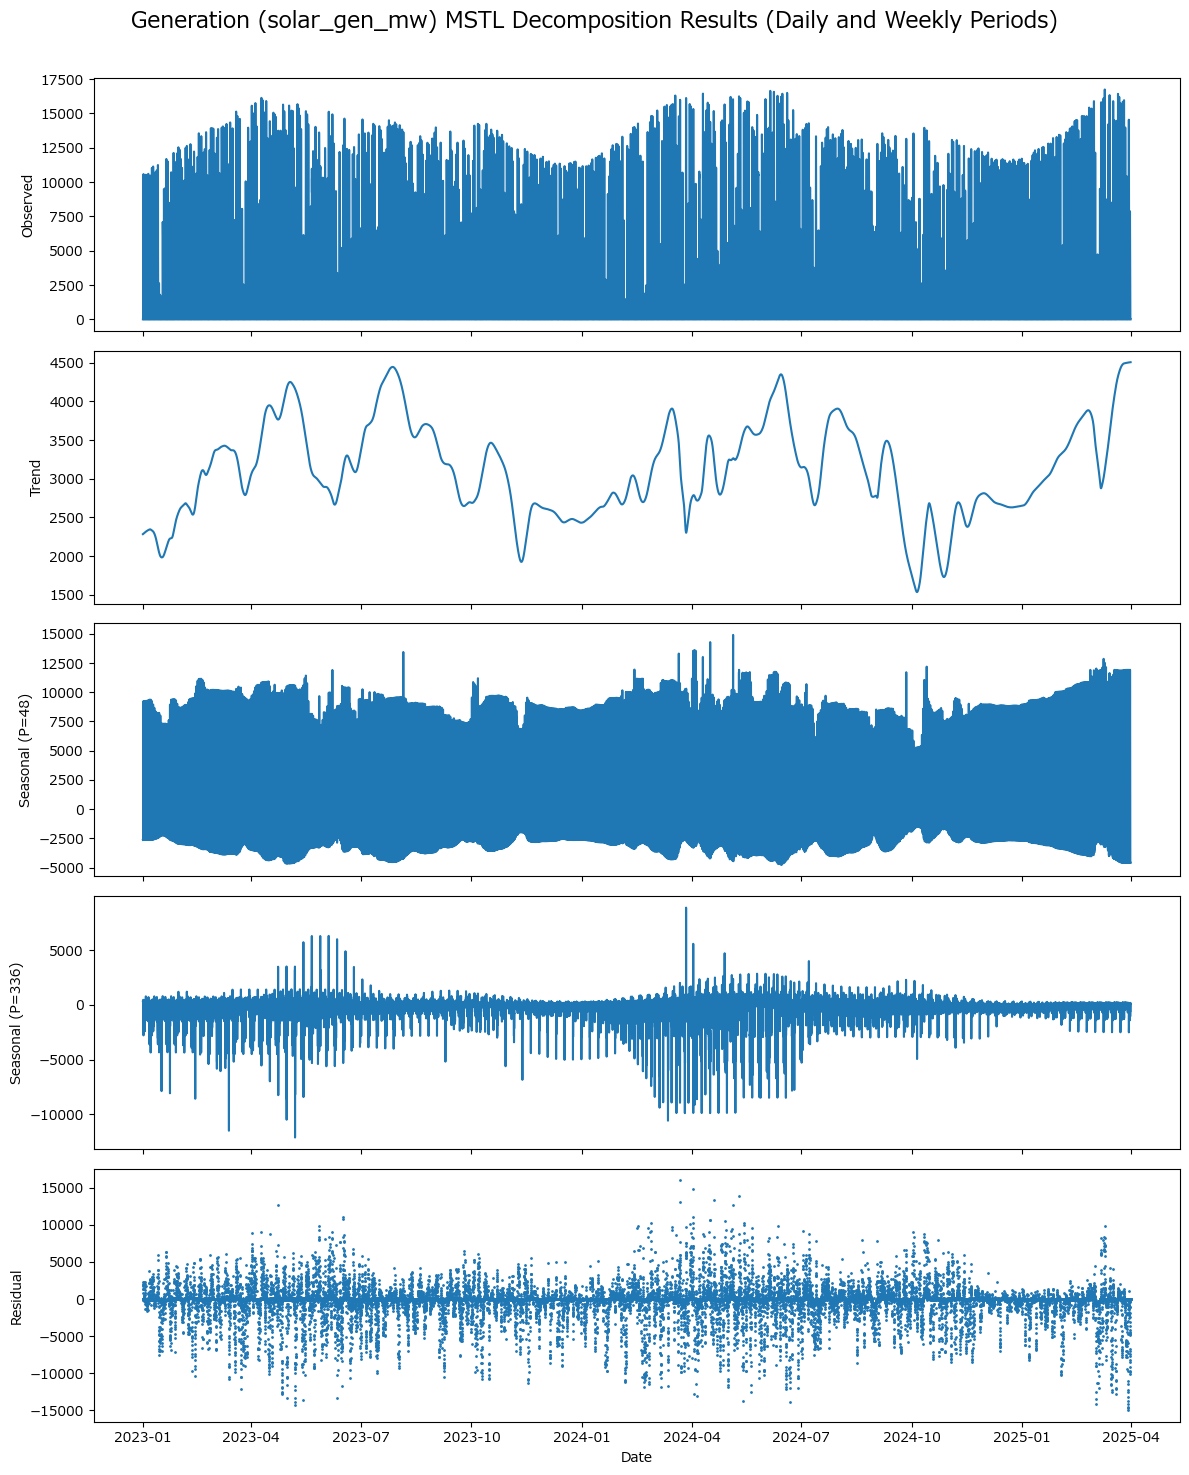

In [5]:
perform_mstl_decomposition(series_gen, "Generation (solar_gen_mw)", periods=PERIODS)

#### 2-2-2. Decomposition Results of Demand (e_demand_mw)


  MSTL Decomposition: Demand (e_demand_mw) (Periods: [48, 336])


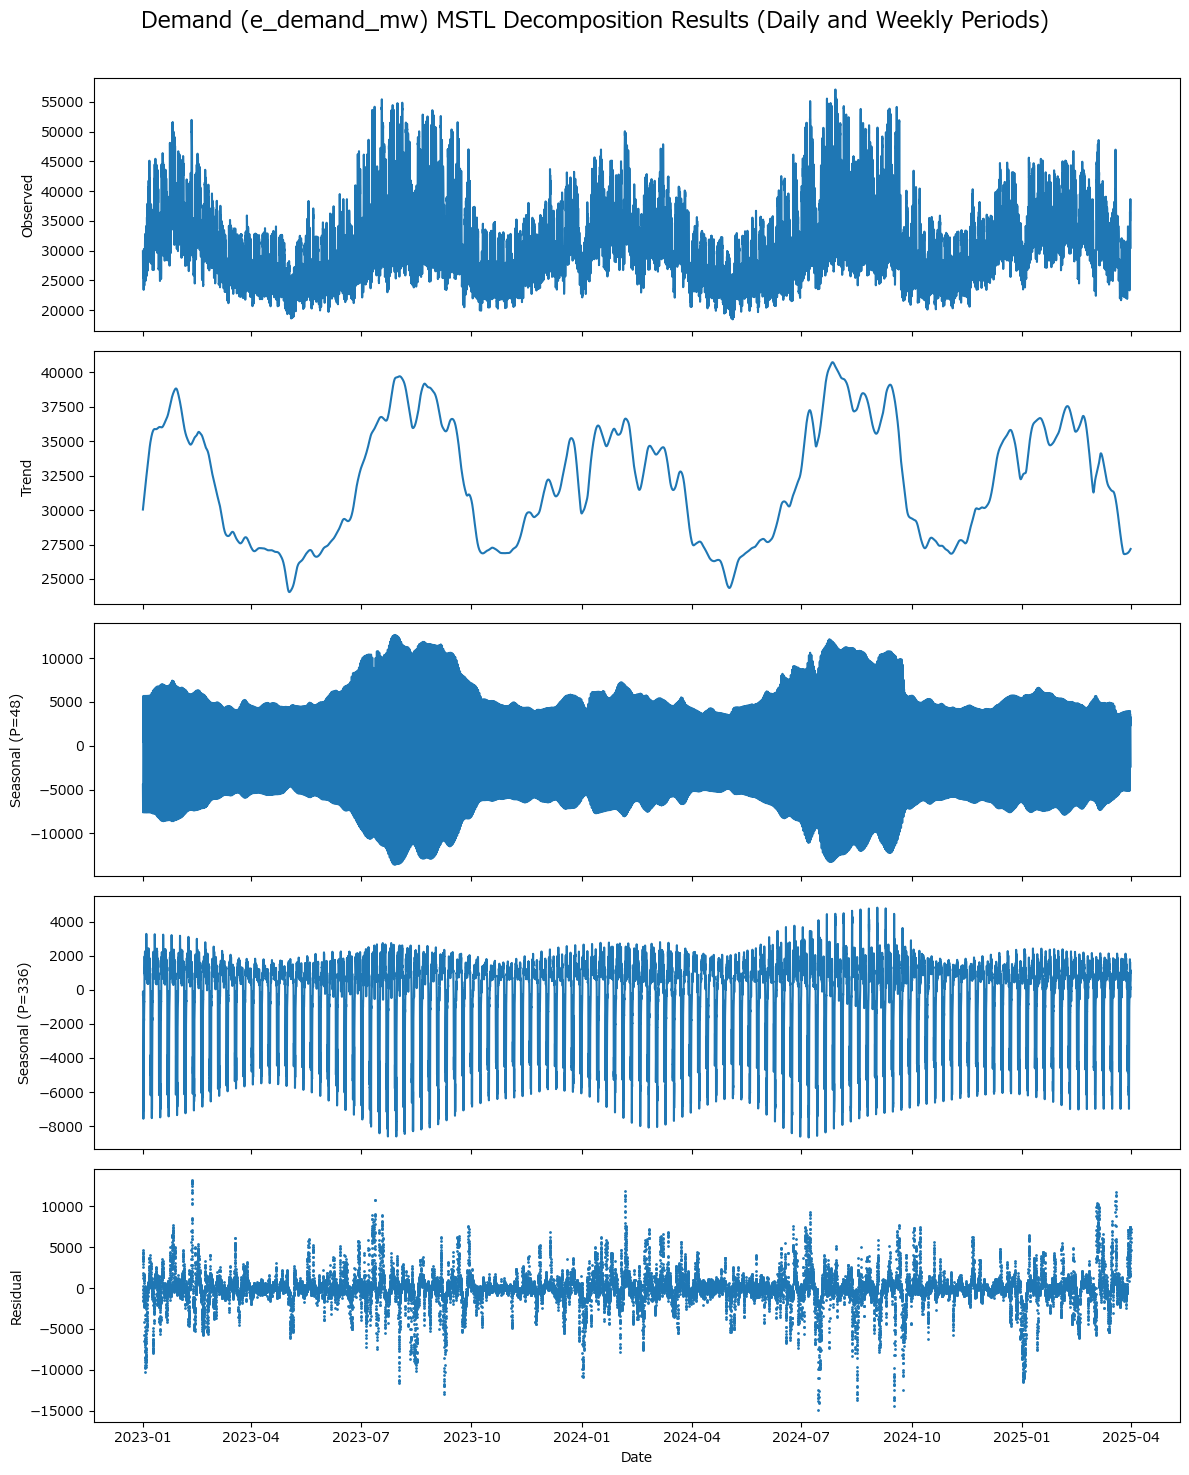

In [6]:
perform_mstl_decomposition(series_demand, "Demand (e_demand_mw)", periods=PERIODS)

### 2-3. Analysis of Long-Term Fluctuations using MSTL Decomposition with an Added Annual Cycle
- To observe the influence of long-term cycles beyond weekly, the annual cycle (17529 frames) is added to MSTL for decomposition.

In [7]:
# Define period list including annual cycles
PERIODS_YEAR = [48, 336, 17520] # days, weeks, years

print(f"MSTL analysis (including annual cycle) ready. Periods: {PERIODS_YEAR}")

MSTL analysis (including annual cycle) ready. Periods: [48, 336, 17520]


In [8]:
def perform_mstl_decomposition_3_periods(series, series_name, periods):
    """Function to perform MSTL decomposition with 3 periods and visualize the results with matplotlib"""

    print(f"\n==================================================")
    print(f"  MSTL Decomposition: {series_name} (Periods: {periods})")
    print(f"==================================================")
    
    # Perform MSTL decomposition
    mstl = MSTL(
        series.dropna(), 
        periods=periods, 
        stl_kwargs={"robust": True, "seasonal_deg": 0}
    )
    res = mstl.fit()

    # --- Visualize with matplotlib (increase subplots to 6) ---
    fig, axes = plt.subplots(6, 1, figsize=(12, 18), sharex=True)
    fig.suptitle(f"{series_name}'s MSTL Decomposition Results (Daily, Weekly, Yearly Periods)", fontsize=16)

    # Observed
    axes[0].plot(res.observed)
    axes[0].set_ylabel("Observed")

    # Trend
    axes[1].plot(res.trend)
    axes[1].set_ylabel("Trend")

    # Seasonality 1 (Daily Period)
    axes[2].plot(res.seasonal.iloc[:, 0])
    axes[2].set_ylabel(f"Seasonal (P={periods[0]})")

    # Seasonality 2 (Weekly Period)
    axes[3].plot(res.seasonal.iloc[:, 1])
    axes[3].set_ylabel(f"Seasonal (P={periods[1]})")

    # Seasonality 3 (Yearly Period)
    axes[4].plot(res.seasonal.iloc[:, 2])
    axes[4].set_ylabel(f"Seasonal (P={periods[2]})")

    # Residual
    axes[5].plot(res.resid, marker='.', linestyle='None', markersize=2)
    axes[5].set_ylabel("Residual")
    axes[5].set_xlabel("Date")

    plt.tight_layout(rect=[0, 0, 1, 0.97]) # Adjust overlap with suptitle
    plt.show()

#### 2-3-2. Power Generation (solar_gen_mw) Decomposition Results (including annual cycle)


  MSTL Decomposition: Power Generation (solar_gen_mw) (Periods: [48, 336, 17520])


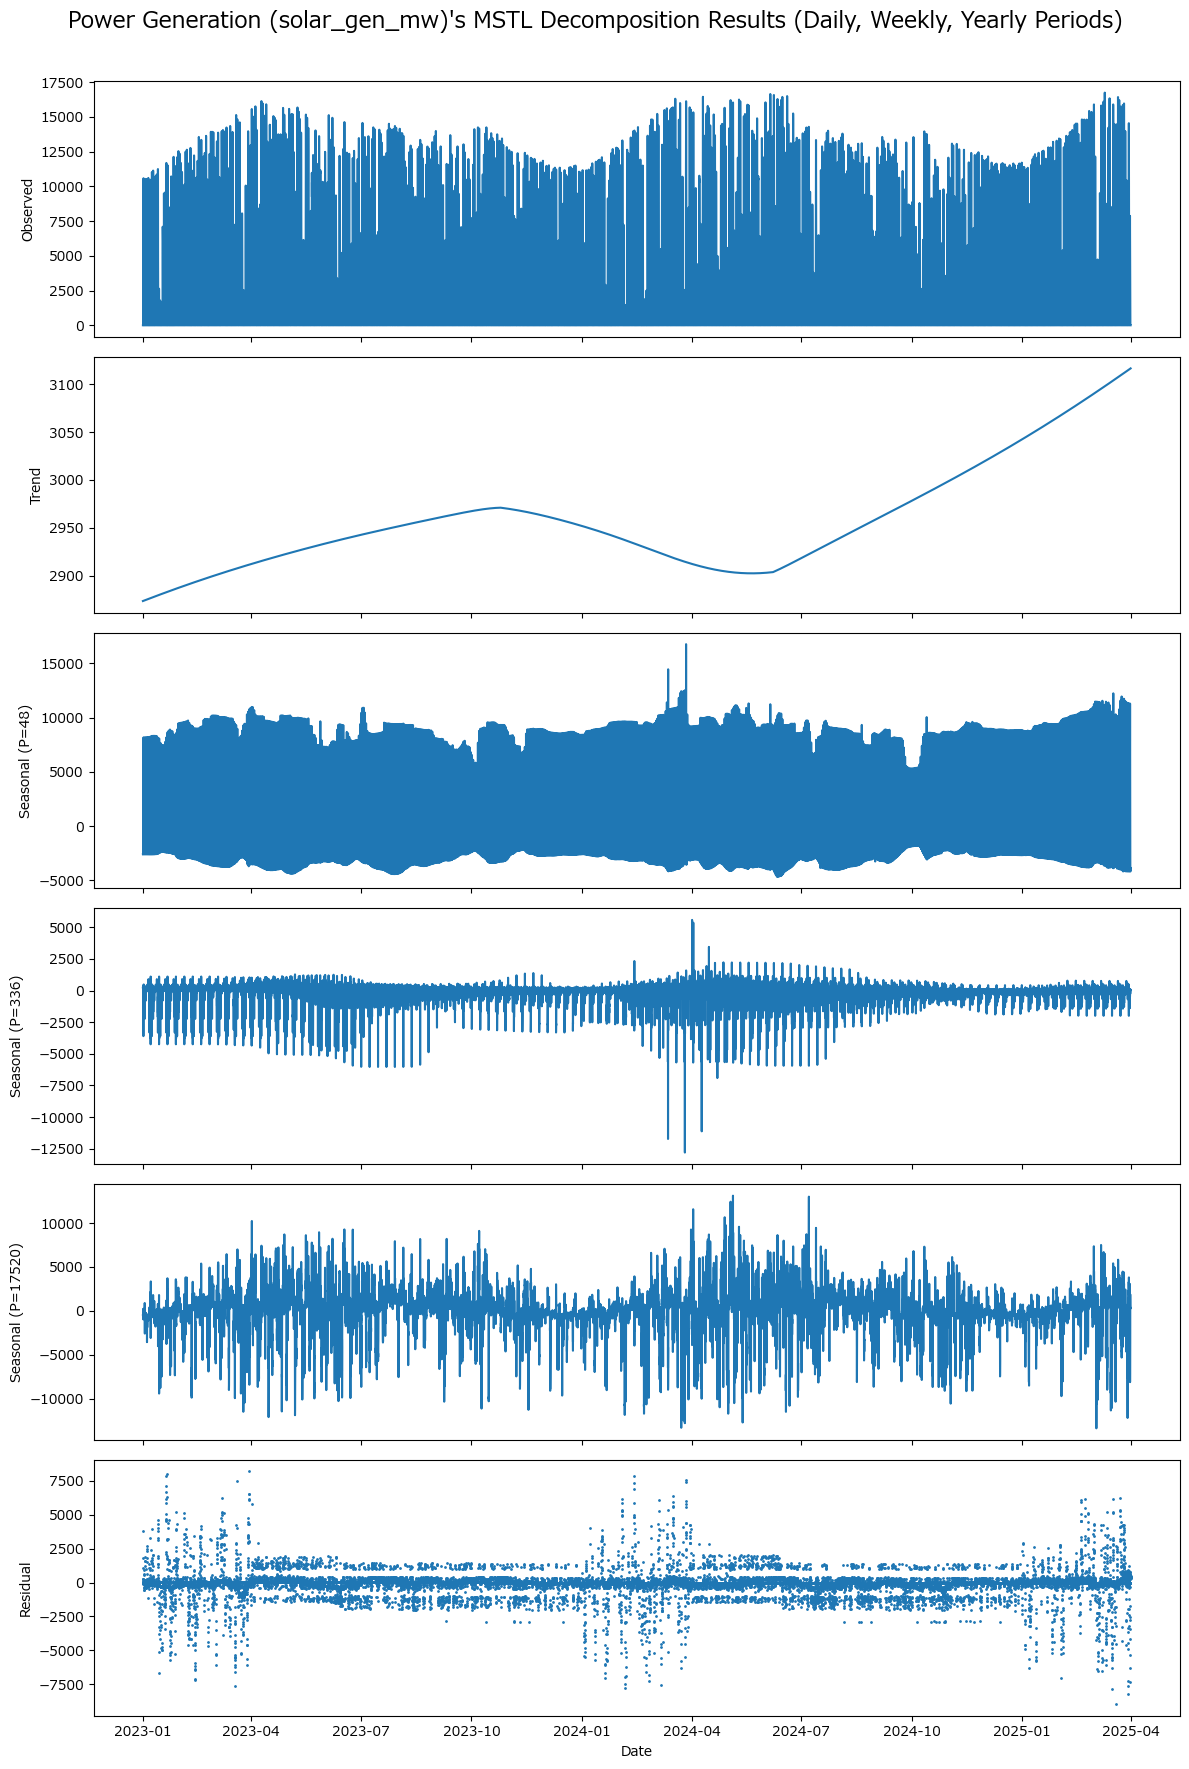

In [9]:
# Perform MSTL decomposition including annual cycles on power generation. Note execution time (e.g., 128m).
perform_mstl_decomposition_3_periods(series_gen, "Power Generation (solar_gen_mw)", periods=PERIODS_YEAR)

#### 2-3-3. Demand (e_demand_mw) Decomposition Results (Including Annual Cycle)


  MSTL Decomposition: Consumption (e_demand_mw) (Periods: [48, 336, 17520])


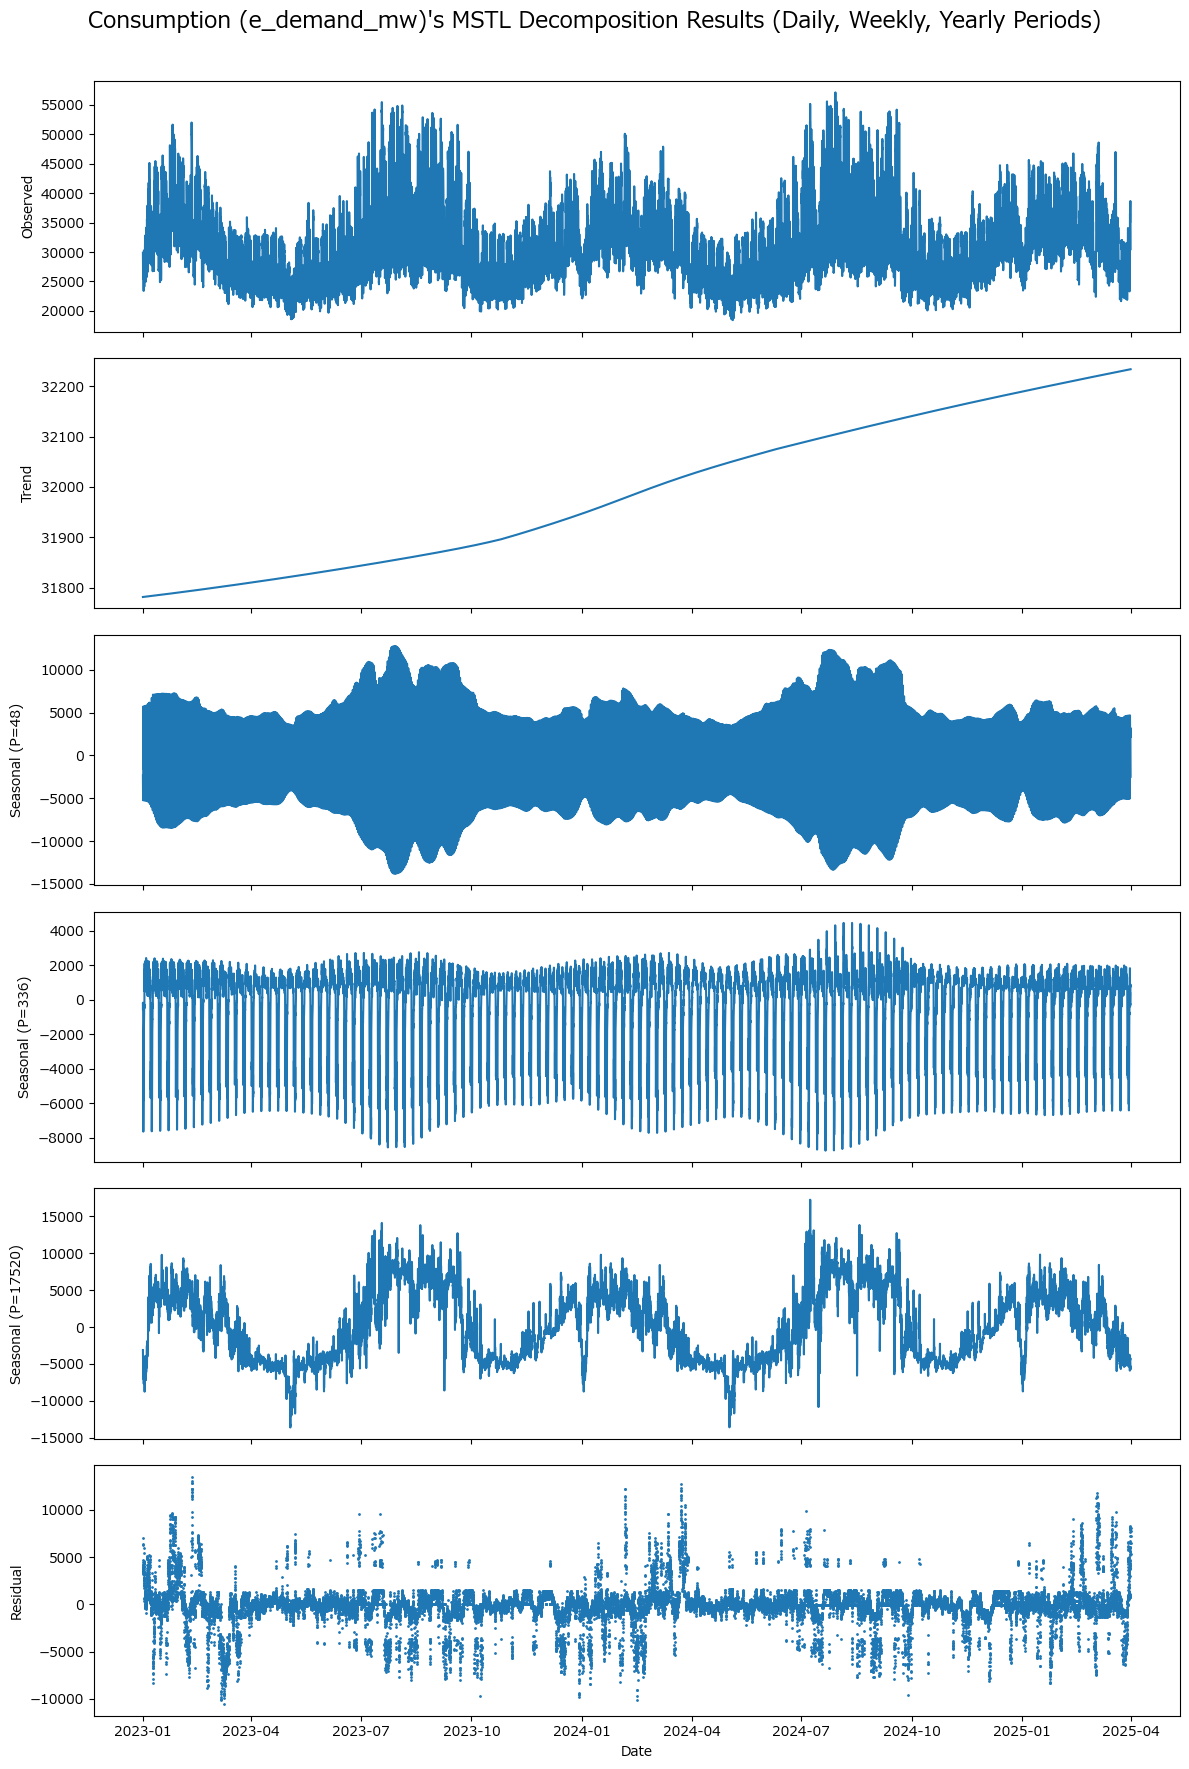

In [10]:
# Perform MSTL decomposition including annual cycles for demand
perform_mstl_decomposition_3_periods(series_demand, "Consumption (e_demand_mw)", periods=PERIODS_YEAR)

### 2-4. Conclusion and Transition to Next Steps

1. Confirmation of Multiple Periodicity and Trend Separation

* For both power generation and demand, the presence of an annual cycle (17,520 intervals) was suggested, in addition to daily (48 intervals) and weekly (336 intervals) cycles. (Power generation is supported by the sun's angle of incidence, and consumption by heating/cooling demand due to temperature and human activity.)

* The simplification of the trend line by separating long-term seasonal fluctuations from the trend component through the addition of an annual cycle suggests the effectiveness of the decomposition.

2. Limitations and Challenges of MSTL

* Extracting seasonal components using MSTL is challenging for intuitive interpretation of each component's pattern, as multiple cycles are intricately intertwined.

* Furthermore, for data where values become zero at night, such as solar power generation, linear methods like STL/MSTL may leave significant bias in the residuals, indicating a high difficulty in modeling.

3. Shift in Analysis Policy for the Next Step

* To leverage complex multiple periodic patterns for model construction, the analysis policy in the next step will shift to **time-based aggregation**. Specifically, the aim is to visualize average patterns by time of day, day of the week, etc., to grasp time-series fluctuation factors more intuitively and quantitatively.